# Recommender Systems Assignment

## Introduction

The purpose of this notebook is the comparison of two approaches for recommender systems:

1. Collaborative filtering without neural component
2. Autoencoder

The small education MovieLens dataset (100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018) was used for this purpose. [1]

### Data set

From the readme:

"This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.

This is a development dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available benchmark datasets if that is your intent.

This and other GroupLens data sets are publicly available for download at http://grouplens.org/datasets/."

## Evaluation criteria

I used MAE as a performance metric. This may be not the best metric to evaluate recommender systems. Another approach would have been to use the "precision at top k" metric which shows the percentage of recommendations in the users top k withheld ratings.

### Data exploration

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [4]:
ratings_file_path = './ml-latest-small/ratings.csv'
movies_file_path = './ml-latest-small/movies.csv'

# Load movies data
movies = pd.read_csv(movies_file_path)
# Load ratings data
df = pd.read_csv(ratings_file_path)
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Check for NaN values -> no NaN values
df.isnull().sum().sum()

0

In [6]:
# Min and Max of the rating column to check for anomalies
print(f'Minimum rating in frame: {df["rating"].min()}')
print(f'Maximum rating in frame: {df["rating"].max()}')

Minimum rating in frame: 0.5
Maximum rating in frame: 5.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c1b2438>]],
      dtype=object)

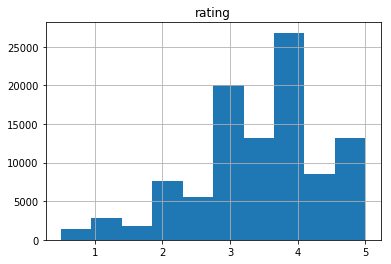

In [7]:
# Histogramm of the ratings
df.hist(column='rating')

In [8]:
# Number of users and movies
print(f'Number of unique users: {df["userId"].nunique()}')
print(f'Number of unique movies: {df["movieId"].nunique()}')

# Average rating and 50th percentile of all movies
print(f'The average rating is {df["rating"].mean()} and the 50th percentile is: {df["rating"].quantile(.5)}')

Number of unique users: 610
Number of unique movies: 9724
The average rating is 3.501556983616962 and the 50th percentile is: 3.5


In [9]:
# Users who rated the least amount of movies --> each user rated at least 20 movies
df.groupby('userId')['userId'].count() \
                              .reset_index(name='count') \
                              .sort_values(['count']) \
                              .head()

,userId,count
441,442,20
405,406,20
146,147,20
193,194,20
568,569,20


In [10]:
# Users who rated the most amount of movies
df.groupby('userId')['userId'].count() \
                              .reset_index(name='count') \
                              .sort_values(['count']) \
                              .tail()

,userId,count
273,274,1346
447,448,1864
473,474,2108
598,599,2478
413,414,2698


## Collaborative filtering approach

In this section an item-item collaborative filtering approach will be laid down. In the first part the algorithm to predict a certain rating of user x for movie y will be established. The second part will evalute this approach.

### Implemented algorithm

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
# Creating the utility matrix
# This may be not possible with a very large dataset but with the size of this data set it works fine
utility_matrix = df.pivot(index='movieId', columns='userId', values='rating')

Creating the similarity matrix has a time complexity of O(n*(n-1)/2) (approx. n^2) and the siliarity matrix has to be updated periodically (perhaps once a day) so new user ratings get included.

In [79]:
def create_sim_matrix(utility_matrix):
    # Calculating the mean rating for each movie (we need this to normalize the ratings for the centered cosine similarity)
    mu = utility_matrix.mean(axis=1, skipna=True).reset_index(name='mu')

    # Converting the df into a an array to subtract from the utility matrix df
    mu = mu['mu'].values
    
    # Subtracting the mean from the ratings and filling the NaN values of the utility matrix with zeroes
    utma_norm = utility_matrix.sub(mu, axis='rows')
    utma_norm_filled = utma_norm.fillna(0)
    
    # calculate a similarity matrix (similarity between two items) --> shape is (9724,9724). Using cosine similarity
    sim_matrix = cosine_similarity(utma_norm_filled)
    
    return sim_matrix, mu, utma_norm

In [80]:
sim_matrix, mu, normalized_utility_matrix = create_sim_matrix(utility_matrix)

In [102]:
# Predicts the rating for movie x by user y with a certain neighborhood_size
def predict_rating(movie_x, user_y, neighborhood_size, sim_matrix, mu, utility_matrix, normalized_utility_matrix):
    # Get the indices of all movies rated by user_y
    movie_vector = normalized_utility_matrix.iloc[:, user_y].values
    indices = np.argwhere(~np.isnan(movie_vector))
    
    # Get the ratings of similar movies which also were rated by user_y
    sim_values = dict()
    for index in indices:
        index = index[0]
        sim_value = sim_matrix[movie_x][index]
        sim_values[index] = sim_value

    # Sort the dict by value --> results in an array from which I take the neighborhood_size + 1 top items
    sim_sorted = sorted(sim_values.items(), key=lambda x: x[1], reverse=True)
    neighbors = sim_sorted[:neighborhood_size+1]
    
    # Calculate the weighted average --> other metrics may result in better predictions 
    weighted_average = 0
    norm_term = 0
    
    # Variable to check if movie_x itself is in neighborhood
    self_similarity = False    
    
    for index, (movie_index, sim_value) in enumerate(neighbors):
        
        # Check if movie_x is in the neighborhood, if yes skip this loop
        if movie_index == movie_x:
            self_similarity = True
            continue
            
        norm_term += sim_value
        rating = utility_matrix.iloc[movie_index,user_y]
        weighted_average += sim_value*rating
        
        # If the movie_x was not in the neighborhood, abort for loop when index == neighborhood_size 
        if not self_similarity and (index == neighborhood_size):
            break
            
        
    # If no prediction can be made, predict the mean rating of the movie
    # This is the case if norm_term == 0
    if norm_term == 0:
        return mu[movie_x]

    predicted_rating = weighted_average / norm_term
    
    # If no prediction can be made, predict the mean rating of the movie
    # This may be the case in a cold start scenario
    if np.isnan(predicted_rating):
        return mu[movie_x]
    
    return predicted_rating

### Evaluating the approach

To evaluate this approach a Test set will be split from the utility matrix. Following the split, predictions will be made for the already known, but to the system withheld, ratings. These predictions will be compared with the actual ratings with the help of the MAE metric. **T** are all the known ratings in the test set. I chose this metric because it is pretty easy to interpret (mean deviation of a predicted rating from the actual rating):

$$
MAE = \frac{\sum_{(x,i)\in T} |(\hat{r}_{x,i}-r_{x,i})|}{N} \\
\begin{align}
\hat{r}_{x,i} = \textrm{predicted rating} && r_{x,i} = \textrm{actual rating} && N = |T| 
\end{align}
$$

A part of the ratings of the utility matrix will be erased, so we can evaluated on this part with the MAE. Like shown in this image [3]:
![Test set split](images/test_set.png "Test set split")



In [103]:
# Create dataset with part of the utility matrix erased, to calculate RMSE
num_users_not_known = int(df["userId"].nunique() * 0.3)
num_ratings_not_known = int(df["movieId"].nunique() * 0.3)

# Creating the utility matrix
# This may be not possible with a very large dataset but with the size of this data set it works fine
utility_matrix = df.pivot(index='movieId', columns='userId', values='rating')
# print(utility_matrix.head)
# Get a slice out of the original utility matrix
known_ratings = utility_matrix.iloc[:num_ratings_not_known,:num_users_not_known]

# Subtract this slice from the original utility matrix, thus setting the ratings to 0 in this part 
# and recombine it with the original utility matrix 
training_data = utility_matrix.subtract(known_ratings).combine_first(utility_matrix).reindex_like(utility_matrix)

In [104]:
# Calculates MAE for a given neighborhood size and sim_matrix
def calc_MAE(neighborhood_size, sim_matrix, mu, utility_matrix, normalized_utility_matrix, naive=False):
    
    MAE = 0
    counter = 0
    for user in range(num_users_not_known):
        for movie in range(num_ratings_not_known):
            # Check if user rated movie in original dataset
            if np.isnan(utility_matrix.iloc[movie, user]):
                continue
                
            # Increase the MSE
            if naive:
                MAE += np.abs(mu[movie] - utility_matrix.iloc[movie, user])
            else:
                # If this is the case, predict the rating with the help of only the train dataset
                predicted_rating = predict_rating(movie, user, neighborhood_size, sim_matrix, mu, utility_matrix, normalized_utility_matrix)
                    
                MAE += np.abs(predicted_rating - utility_matrix.iloc[movie, user])
            counter += 1
    
    # Calculate the RMSE
    MAE /= counter
    
    return MAE 

In [105]:
# Create new similarity matrix out of the training utility matrix
sim_matrix_training, mu, normalized_utility_matrix = create_sim_matrix(training_data)

In [108]:
mae_naive = calc_MAE(1, sim_matrix_training, mu, utility_matrix, normalized_utility_matrix, naive=True)
print(mae_naive)

1.3192894831656001


In [109]:
# Calculates MAE for the collaborative filtering approach and a naive approach where the recommended rating 
# is just the mean of a movie
results_cf = []

# Small neighborhood sizes
for neighborhood_size in range(1,15,3):
    mae = calc_MAE(neighborhood_size, sim_matrix_training, mu, utility_matrix, normalized_utility_matrix, naive=False)
    results_cf.append((neighborhood_size, mae))

# Larger neighborhood sizes
for neighborhood_size in range(15,40,5):
    mae = calc_MAE(neighborhood_size, sim_matrix_training, mu, utility_matrix, normalized_utility_matrix, naive=False)
    results_cf.append((neighborhood_size, mae))

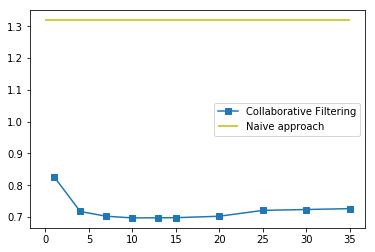

In [110]:
x = [i[0] for i in results_cf]
y = [i[1] for i in results_cf]

plt.hlines(mae_naive, xmin=0, xmax=35, label='Naive approach', colors='y')
plt.plot(x, y, marker='s', label='Collaborative Filtering')
plt.legend(loc='center right')

The optimal neighborhood size is around 10. This corresponds to the evaluation of Sarwar et al. [2]:

![Neighborhood size](images/neighborhood_size.png "Neighborhood Size")

## Autoencoder

**Note**: I'm not at all happy with my model, it seems that it performs equaly good as a naive approach (see evaluation of this model at the end). I think the problem is the sparsity of the input vectors. I tried to regularize the model and implemented a custom loss function, both approaches did not improve the model. Probably it would be best to incorporate the genre data into the movie vectors, so the data contains more valuable information.

### Preparation of training, validation and test data sets

In [ ]:
import tensorflow as tf

# Fixes Mac related problem with matplotlib / tensorflow version
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [648]:
# Load data from df and create utility matrix
utility_matrix = df.pivot(index='movieId', columns='userId', values='rating')

# Normalizing with mean rating
mu = utility_matrix.mean(axis=1, skipna=True).reset_index(name='mu')

mu = mu['mu'].values

# Subtracting the mean from the ratings
utility_matrix = utility_matrix.sub(mu, axis='rows')


# Dimensions of the DataFrame and defining sizes of the different datasets -> training: 0.7, validation: 0.1, test:0.2
num_movies = len(utility_matrix.index)
num_users = len(utility_matrix.columns)
withhold_user_size = int(num_users*0.3)

test_set_size = int(num_movies*0.2)
val_set_size = int(num_movies*0.1)
train_set_size = num_movies - val_set_size - test_set_size

# Test set
utility_matrix_test = utility_matrix.iloc[:test_set_size,:]

# Validation set
utility_matrix_val = utility_matrix.iloc[test_set_size:test_set_size+val_set_size,:]

# Training set
utility_matrix_train = utility_matrix.iloc[test_set_size+val_set_size:,:]

# Preparing the test set the same way as we did for the collaborative filtering approach
utility_matrix_test_known_values = utility_matrix_test.iloc[:,:withhold_user_size]

utility_matrix_test_withhold = utility_matrix_test \
                                        .subtract(utility_matrix_test_known_values) \
                                        .combine_first(utility_matrix_test) \
                                        .reindex_like(utility_matrix_test)


# Fill NaN values with 0
utility_matrix_test_withhold = utility_matrix_test_withhold.fillna(0)
utility_matrix_train = utility_matrix_train.fillna(0)
utility_matrix_val = utility_matrix_val.fillna(0)
utility_matrix_test = utility_matrix_test.fillna(0)

## Model

In [649]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error

In [650]:
# The size of our encoded representations
encoding_dim = 10 

# This is our input placeholder
input_item = Input(shape=(610, )) #9724

# "encoded" is the encoded representation of the inputs
encoded = Dense(encoding_dim * 10, activation='linear', activity_regularizer=regularizers.l1(10e-5))(input_item)
encoded = Dropout(0.75)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(encoding_dim * 10, activation='relu')(encoded)
decoded = Dense(610)(decoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_item, decoded)

In [652]:
# Separate Encoder model (may be of interest to see the encoded input)

encoder = Model(input_item, encoded)

# Separate Decoder model (may be of interest too)


encoded_input = Input(shape=(encoding_dim, ))

# Retrieve the layers of the autoencoder model
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]

# Create the decoder model
decoder = Model(encoded_input, decoder_layer2(decoder_layer1(encoded_input)))

In [653]:
# Adjusted loss function -> only take the mse of values where y_true != 0
def adjusted_mean_squared_error(y_true, y_pred):

    y_true = y_true * (y_true != 0) 
    y_pred = y_pred * (y_true != 0)

    error = K.mean(K.square(y_pred - y_true), axis=-1)
    return error

In [654]:
# configure model to use a mean squared error loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss=adjusted_mean_squared_error)

# Train autoencoder for 50 epochs with batch size of 100 samples
my_epochs = 50
autoencoder.fit(utility_matrix_train, utility_matrix_train, epochs=my_epochs, 
                batch_size=100, shuffle=True, validation_data=(utility_matrix_val, utility_matrix_val),
                verbose=2)

# Safe the model
autoencoder.save('autoencoder.h5')


Train on 6808 samples, validate on 972 samples
Epoch 1/50
 - 13s - loss: 0.0084 - val_loss: 0.0188
Epoch 2/50
 - 1s - loss: 0.0082 - val_loss: 0.0187
Epoch 3/50
 - 2s - loss: 0.0080 - val_loss: 0.0186
Epoch 4/50
 - 1s - loss: 0.0079 - val_loss: 0.0186
Epoch 5/50
 - 2s - loss: 0.0079 - val_loss: 0.0185
Epoch 6/50
 - 2s - loss: 0.0078 - val_loss: 0.0185
Epoch 7/50
 - 2s - loss: 0.0078 - val_loss: 0.0185
Epoch 8/50
 - 2s - loss: 0.0078 - val_loss: 0.0185
Epoch 9/50
 - 2s - loss: 0.0077 - val_loss: 0.0184
Epoch 10/50
 - 2s - loss: 0.0077 - val_loss: 0.0184
Epoch 11/50
 - 1s - loss: 0.0077 - val_loss: 0.0184
Epoch 12/50
 - 2s - loss: 0.0077 - val_loss: 0.0184
Epoch 13/50
 - 2s - loss: 0.0077 - val_loss: 0.0184
Epoch 14/50
 - 2s - loss: 0.0076 - val_loss: 0.0184
Epoch 15/50
 - 2s - loss: 0.0076 - val_loss: 0.0184
Epoch 16/50
 - 1s - loss: 0.0076 - val_loss: 0.0184
Epoch 17/50
 - 2s - loss: 0.0076 - val_loss: 0.0184
Epoch 18/50
 - 2s - loss: 0.0076 - val_loss: 0.0184
Epoch 19/50
 - 2s - loss:

In [579]:
# Here you can load the trained model
autoencoder = load_model('autoencoder.h5', custom_objects={'adjusted_mean_squared_error': adjusted_mean_squared_error})

### Calulate MAE of the autoencoder

I use the MAE metric for evaluation of the autoencoder. 

In [ ]:
def calc_MAE_ae(predictions, test_set_original, withhold_ratings):
    
    MAE = 0
    counter = 0
    # For every movie and user of the withheld area
    for movie in range(predictions.shape[0]):
        for user in range(withhold_ratings):
            
            # Check if user rated movie in original dataset
            if test_set_original.iloc[movie, user] == 0:
                continue
                
            # If this is the case, update the MAE
            MAE += np.abs((predictions[movie][user]) - (test_set_original.iloc[movie,user]))
            counter += 1
    
    # Calculate the RMSE
    MAE /= counter
    
    return MAE 

Autoencoder evaluation:

In [661]:
ae_predictions = autoencoder.predict(utility_matrix_test_withhold)
autoencoder_mae = calc_MAE_ae(ae_predictions, utility_matrix_test, withhold_user_size)
print(autoencoder_mae)

0.7364273025506585


To compare this value with a "random" approach, in which "the prediction" is just the mean value of a movie, I use the MAE on a empty predictions matrix:

In [662]:
naive_predictions = pd.DataFrame(0, columns=utility_matrix_test_withhold.columns, 
                                 index=utility_matrix_test_withhold.index) \
                                .values
naive_mae = calc_MAE_ae(naive_predictions, utility_matrix_test, withhold_user_size)
print(naive_mae)

0.7377172587596565


## Sources

[1] F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

[2] Sarwar, B. M., Karypis, G., Konstan, J. A., & Riedl, J. (2001). Item-based collaborative filtering recommendation algorithms. Www, 1, 285-295.

[3] Leskovec, Rajaraman and Ullman: Lecture 45 — Evaluating Recommender Systems | Stanford University, https://www.youtube.com/watch?v=VZKMyTaLI00&t=264s
